# Base setting

In [1]:
!pip install torch # 실습 환경에선 주석처리 가능.
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.data import download_url, extract_zip

from sklearn import model_selection, metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import random
from tqdm.notebook import tqdm
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [4]:
# url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
# extract_zip(download_url(url, '.'), '.')

# ratings_path = './ml-latest-small/ratings.csv' # need to fix
ratings_path = 'ml-latest-small/ratings.csv'
df = pd.read_csv(ratings_path)

print(len(df)) # number of data
print(df['userId'].nunique()) # number of users
print(df['movieId'].nunique()) # number of movies

100836
610
9724


In [5]:
# need to fix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Neural Collaborative filtering

## 1. Data_preprocessing

In [6]:
# Generate Dataloader object (used as input data for model)
class MovieLens:
  def __init__(self, users, movies, ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings

  def __len__(self):
    return len(self.users)

  def __getitem__(self,item):
    '''
    item = randomly selected indexes for (user,item) pairs
    '''
    users = self.users[item]
    movies = self.movies[item]
    ratings = self.ratings[item]
    return {'users': torch.tensor(users, dtype = torch.long).to(device),
            'movies': torch.tensor(movies, dtype = torch.long).to(device),
            'ratings': torch.tensor(ratings, dtype=torch.long).to(device)}

In [7]:
# convert actual index for user and items as consecutive integer
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

# devide original dataframe into train, test dataframe (9:1)
df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df.rating.values)

train_dataset = MovieLens(users = df_train.userId.values, movies = df_train.movieId.values, ratings = df_train.rating.values)
test_dataset = MovieLens(users = df_test.userId.values, movies = df_test.movieId.values, ratings = df_test.rating.values)

print(len(train_dataset))
print(len(test_dataset))

90752
10084


## 2. Model setting

In [8]:
### Embedding layer + NCF layer
# 2-layer(including output layer)

# hidden layer + active layer(RELU) + output
# latent vector dim: 32
# input dim: 64

class Neural_Collaborative_Filtering(nn.Module):
  def __init__(self, n_users, n_movies):
    '''
    n_users = # of users
    n_movies = # of movies
    '''
    super().__init__()
    # convert all users and items into 32-dim learnable latent factors(vectors)
    self.user_embedding = nn.Embedding(n_users, 32)
    self.movie_embedding = nn.Embedding(n_movies, 32)

    # Neural network for rating prediction
    self.fc1 = nn.Linear(64,32) # 64 = user_i embedding + movie_j embedding
    self.relu = nn.ReLU()
    self.fc2= nn.Linear(32,1)

  def forward(self, users, movies, ratings = None):
    user_embedding = self.user_embedding(users)
    movie_embedding = self.movie_embedding(movies)
    input_embedding = torch.cat([user_embedding, movie_embedding], dim = 1)

    hidden_feature = self.fc1(input_embedding)
    hidden_feature = self.relu(hidden_feature)

    output = self.fc2(hidden_feature) # output is prediction

    return output

## 3. Training

In [9]:
# set batch
train_loader = DataLoader(dataset = train_dataset, batch_size=128, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset = test_dataset, batch_size=128, shuffle=True, drop_last = False)

In [10]:
# model instance generation
model = Neural_Collaborative_Filtering(n_users = len(lbl_user.classes_), n_movies = len(lbl_movie.classes_)).to(device)

# Optimizer, Objective function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.MSELoss(reduction= 'mean')

In [11]:
epochs = 10
total_loss = 0
iter_cnt = 0
all_losses_list = []

model.train()

for epoch in range(1, epochs+1):
  total_loss = 0
  epoch_check = 0
  for i, train_data in enumerate(train_loader):
    '''
    train_data = {'users':[], 'items':[], 'ratings':[]}
    '''
    batch_size = len(train_data['users'])
    prediction = model(train_data['users'], train_data['movies'])
    ground_truth = train_data['ratings'].view(batch_size,-1).to(torch.float32)

    loss = loss_func(prediction, ground_truth)
    total_loss = total_loss + (loss.item() * batch_size)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter_cnt = iter_cnt + 1
    epoch_check += batch_size

    if iter_cnt % 100 == 0 and iter_cnt != 0:
      avg_iter_loss = loss.item()
      batch_num = int((iter_cnt/100) % 7) if int((iter_cnt/100) % 7) else 7
      print(f"epoch {epoch} - (batch {batch_num}) loss : {(avg_iter_loss)}")


    if epoch_check % (batch_size * len(train_loader)) == 0 and epoch_check != 0:
      avg_loss = total_loss / epoch_check
      print(f"Epoch {epoch} Avg_loss : {avg_loss}")
      all_losses_list.append(avg_loss)


epoch 1 - (batch 1) loss : 4.462433815002441
epoch 1 - (batch 2) loss : 2.074892520904541
epoch 1 - (batch 3) loss : 1.2041988372802734
epoch 1 - (batch 4) loss : 1.4329631328582764
epoch 1 - (batch 5) loss : 1.3442317247390747
epoch 1 - (batch 6) loss : 1.144464373588562
epoch 1 - (batch 7) loss : 1.1915597915649414
Epoch 1 Avg_loss : 2.4021738596123936
epoch 2 - (batch 1) loss : 0.9749795198440552
epoch 2 - (batch 2) loss : 0.8154403567314148
epoch 2 - (batch 3) loss : 0.7887318730354309
epoch 2 - (batch 4) loss : 1.111114501953125
epoch 2 - (batch 5) loss : 0.8633134365081787
epoch 2 - (batch 6) loss : 0.8488587141036987
epoch 2 - (batch 7) loss : 1.043222188949585
Epoch 2 Avg_loss : 1.025171792053201
epoch 3 - (batch 1) loss : 1.056288242340088
epoch 3 - (batch 2) loss : 1.0395622253417969
epoch 3 - (batch 3) loss : 1.0311017036437988
epoch 3 - (batch 4) loss : 0.818798840045929
epoch 3 - (batch 5) loss : 0.8606249690055847
epoch 3 - (batch 6) loss : 1.0330653190612793
epoch 3 - (b

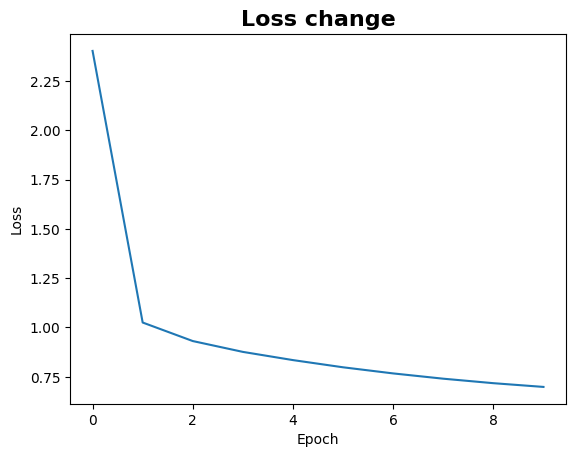

In [12]:
# Show Loss change
plt.figure()

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

plt.title('Loss change',fontdict=title_font)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(all_losses_list)
plt.show()

## 4. Evaluation

### RMSE

In [13]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
  for i, batched_data in enumerate(test_loader):
    model_output = model(batched_data['users'],batched_data['movies'])
    model_output_batch = model_output.cpu().numpy().squeeze(axis=1).tolist()
    model_output_list += (model_output_batch)

    target_rating = batched_data['ratings']
    target_rating_batch = target_rating.cpu().numpy().tolist()
    target_rating_list += target_rating_batch

mse = mean_squared_error(target_rating_list, model_output_list)
rms = np.sqrt(mse)
print(f"rms: {rms}")

rms: 0.9398793789625983


### Recall@k & Precision@k

In [14]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
  for i, batched_data in enumerate(test_loader):
    users = batched_data['users']
    movies = batched_data['movies']
    ratings = batched_data['ratings']

    model_output = model(batched_data['users'], batched_data["movies"])

    for i in range(len(users)):
      user_id = users[i].item()
      movie_id = movies[i].item()
      pred_rating = model_output[i][0].item()
      true_rating = ratings[i].item()

      user_est_true[user_id].append((pred_rating, true_rating))

In [15]:
with torch.no_grad():
  precisions = dict()
  recalls = dict()

  # recall@K
  k= 10
  threshold = 3.5 # relevant item criterion

  for user_id, user_ratings in user_est_true.items():
    user_ratings.sort(key=lambda x: x[0], reverse =True)

    # get the number for real relevant items = denominator of recall@k
    n_real_relevant= sum((true_r >= threshold) for (_, true_r) in user_ratings)

    # k recommended ratings
    recommended_k = user_ratings[:k]

    # get the number of recommented item that is actually relevant with real relevant.
    n_real_relevant_in_top_k = sum((true_r >= threshold) for (est, true_r) in recommended_k)

    # precision@k
    precisions[user_id] = n_real_relevant_in_top_k / 10
    # recall@k
    if n_real_relevant:
      recalls[user_id] = n_real_relevant_in_top_k / n_real_relevant

    else:
      recalls[user_id] = 0


In [16]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")

precision @ 10: 0.4171666666666667
recall @ 10 : 0.749242890920852
